In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
from phys_ml.util import slurm_generate
from phys_ml.load_data import vertex
from phys_ml.load_data.vertex import *
from phys_ml.trainer import TrainerModes
from phys_ml.trainer.vertex import *
from phys_ml.visualization import vertex_visualization as vertvis

In [47]:
# latent space
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../frgs'})
ls = trainer.load_latentspace('saves/vertex/save_AUTO_ENCODER_VERTEX_BS20_2024-12-06/version_0')
ls.shape

(576, 576, 128)

### slurm

In [ ]:
# generate slurm
trainer_kwargs = {
    'project_name': 'vertex', 
    'config_name': 'confmod_auto_encoder.json', 
    'subconfig_name': 'AUTO_ENCODER_VERTEX', 
    'config_kwargs': {
        'path_train': '/gpfs/data/fs71925/shepp123/frgs',
        'epochs': 100,
        'subset': 10, 
        'subset_shuffle': True, 
        'subset_seed': 42,
    },
}
slurm_options = slurm_generate.SlurmOptions(qos='zen3_0512_a100x2_devel', time='00:10:00')
slurm_generate.create(project_name='vertex', script_name='vsc_test', 
                      pyenv_dir='/gpfs/data/fs71925/shepp123/anaconda3', slurm_options=slurm_options, 
                      trainer='VertexTrainer', trainer_kwargs=trainer_kwargs)


In [ ]:
# create slurm- and train-script from config-file
!python phys_ml/util/slurm_generate.py configs/confmod_auto_encoder_v2.json

# dev

In [64]:
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../frgs', 'subset': 10, 'subset_shuffle': False})

## Transforming 576^3-matrix to 24^6-matrix

In [77]:
vertex.convert_3d_to_6d_vertex('../frgs')

### Tests

In [1]:
### prepare test matrices
import random
import time
import numpy as np


def print_mat_stats(m):
    print(f'dim: {len(m.shape)}, shape: {m.shape}, size: {m.size}, sum: {m.sum()}')
    #print(m)

random.seed(42)
np.random.seed(42)

n_freq = 24
space_dim = 2
k_dim = 3
dim = space_dim * k_dim
length = n_freq**space_dim

#m576_3 = np.ones((length,) * k_dim)
m576_3 = np.random.rand(*((length,) * k_dim))
m24_6 = np.zeros((n_freq,) * dim)
control_idcs = np.random.randint(0, n_freq, (8, dim))
control_items = [m576_3[idx[0] * n_freq + idx[1], 
                        idx[2] * n_freq + idx[3], 
                        idx[4] * n_freq + idx[5]] for idx in control_idcs]
print_mat_stats(m576_3)
print_mat_stats(m24_6)
print('random control indices:\n', control_idcs)
print('random control items:', control_items)

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 0.0
random control indices:
 [[12 11 14  8  5 17]
 [ 6 22  1 20 10  3]
 [15  7 22 10 11  5]
 [12  9  6 11 20 10]
 [ 1 19 18 12  2 13]
 [22 16 11 10  9  9]
 [ 6  0 21 12 11 19]
 [15 12 13 12 15 22]]
random control items: [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [2]:
### method 1
t0 = time.time()


def transform_index(i: int) -> tuple[int, int]:
    return (i // n_freq, i % n_freq)


def transform_indices(*indices: int) -> list[int]:
    return [j for i in indices for j in transform_index(i)]


# unpack to 24^6 matrix
m24_6 = np.empty((n_freq,) * dim)
k = np.arange(length)
for i_k1 in range(length):
    for i_k2 in range(length):
        m24_6[*transform_indices(i_k1, i_k2), k // n_freq, k % n_freq] = m576_3[i_k1, i_k2, :]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 6.784s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [3]:
### method 2
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        for k in range(n_freq):
            m24_6[i, :, j, :, k, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                             j * n_freq : (j + 1) * n_freq, 
                                             k * n_freq : (k + 1) * n_freq]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.907s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [4]:
### method 3
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        m24_6[i, :, j, :, :, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                         j * n_freq : (j + 1) * n_freq, 
                                         :].reshape((n_freq,) * 4)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.541s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [5]:
### method 4
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.117s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [6]:
### counter check
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim, order='F')

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', np.allclose(check_items, control_items), check_items)


time: 0.000s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: False [0.33492172096278894, 0.7445258143299188, 0.7023092181332355, 0.4296937021301115, 0.5976509612927238, 0.47546319469685294, 0.690896655895319, 0.47354879755181545]


In [12]:
# back-conversion
t0 = time.time()

m = m24_6.reshape((length,) * k_dim, order='F')

print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m)
print('element-wise check:', np.allclose(m, m576_3))


time: 0.000s

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
random control items: True


# Vertex Autoencoder

## Visualize

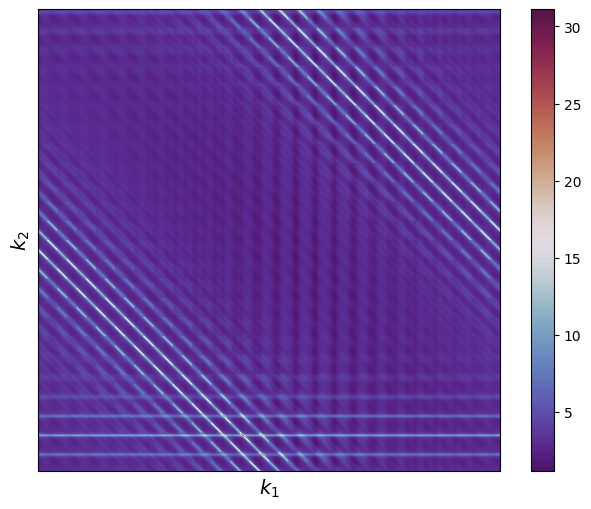

In [29]:
vertex3 = AutoEncoderVertexDataset.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
vertvis.plot_section(vertex3, 255, axis=3, figsize=(8,6))

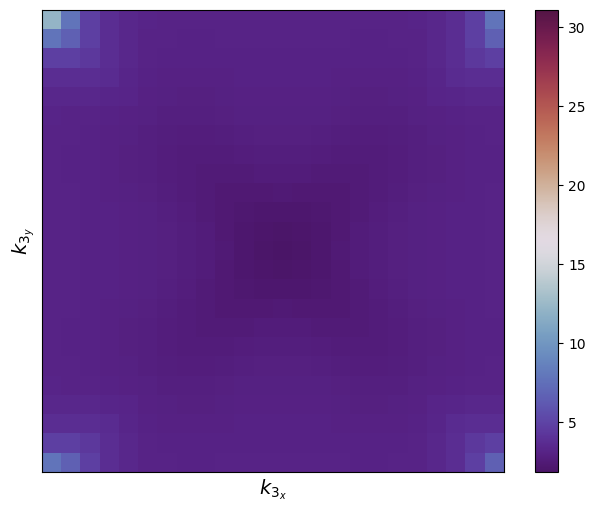

In [20]:
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file('../frgs_6d/tp0.020000_mu0.080000.h5')
i = 12
vertvis.plot_section_24x6(vertex6, k=3, kix=i, kiy=i, kjx=i, kjy=i, figsize=(8,6))

## Training

In [3]:
trainer3 = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                         subconfig_name='AUTO_ENCODER_VERTEX', 
                         config_kwargs={'path_train': '../frgs', 'subset': 10, 'subset_shuffle': False})

In [15]:
trainer6 = VertexTrainer24x6(project_name='vertex_24x6', config_name='confmod_auto_encoder.json', 
                             subconfig_name='AUTO_ENCODER_VERTEX_24X6', 
                             config_kwargs={'path_train': '../frgs_6d', 
                                            'hidden_dims': [128, 64, 32],
                                            'sample_count_per_vertex': 5000, 
                                            'subset': 10, 'subset_shuffle': False})

In [16]:
trainer6.train(train_mode=TrainerModes.LOCAL)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | AutoEncoderVertex | 32.6 K | train
1 | criterion | MSELoss           | 0      | train
--------------------------------------------------------
32.6 K    Trainable params
0         Non-trainable params
32.6 K    Total params
0.130     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 600/600 [00:13<00:00, 45.72it/s, v_num=0, val_loss=1.850]

Epoch 0, global step 600: 'val_loss' reached 1.84993 (best 1.84993), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=0-step=600.ckpt' as top 10


Epoch 1: 100%|██████████| 600/600 [00:05<00:00, 106.71it/s, v_num=0, val_loss=1.120]

Epoch 1, global step 1200: 'val_loss' reached 1.11509 (best 1.11509), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=1-step=1200.ckpt' as top 10


Epoch 2: 100%|██████████| 600/600 [00:05<00:00, 109.95it/s, v_num=0, val_loss=0.679]

Epoch 2, global step 1800: 'val_loss' reached 0.67882 (best 0.67882), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=2-step=1800.ckpt' as top 10


Epoch 3: 100%|██████████| 600/600 [00:05<00:00, 114.59it/s, v_num=0, val_loss=0.573]

Epoch 3, global step 2400: 'val_loss' reached 0.57267 (best 0.57267), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=3-step=2400.ckpt' as top 10


Epoch 4: 100%|██████████| 600/600 [00:05<00:00, 113.93it/s, v_num=0, val_loss=0.458]

Epoch 4, global step 3000: 'val_loss' reached 0.45781 (best 0.45781), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=4-step=3000.ckpt' as top 10


Epoch 5: 100%|██████████| 600/600 [00:05<00:00, 109.68it/s, v_num=0, val_loss=0.378]

Epoch 5, global step 3600: 'val_loss' reached 0.37751 (best 0.37751), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=5-step=3600.ckpt' as top 10


Epoch 6: 100%|██████████| 600/600 [00:05<00:00, 106.48it/s, v_num=0, val_loss=0.343]

Epoch 6, global step 4200: 'val_loss' reached 0.34254 (best 0.34254), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=6-step=4200.ckpt' as top 10


Epoch 7: 100%|██████████| 600/600 [00:05<00:00, 111.25it/s, v_num=0, val_loss=0.310]

Epoch 7, global step 4800: 'val_loss' reached 0.31031 (best 0.31031), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=7-step=4800.ckpt' as top 10


Epoch 8: 100%|██████████| 600/600 [00:06<00:00, 97.50it/s, v_num=0, val_loss=0.285] 

Epoch 8, global step 5400: 'val_loss' reached 0.28495 (best 0.28495), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=8-step=5400.ckpt' as top 10


Epoch 9: 100%|██████████| 600/600 [00:05<00:00, 109.94it/s, v_num=0, val_loss=0.257]

Epoch 9, global step 6000: 'val_loss' reached 0.25727 (best 0.25727), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=9-step=6000.ckpt' as top 10


Epoch 10: 100%|██████████| 600/600 [00:05<00:00, 112.75it/s, v_num=0, val_loss=0.236]

Epoch 10, global step 6600: 'val_loss' reached 0.23550 (best 0.23550), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=10-step=6600.ckpt' as top 10


Epoch 11: 100%|██████████| 600/600 [00:05<00:00, 115.48it/s, v_num=0, val_loss=0.206]

Epoch 11, global step 7200: 'val_loss' reached 0.20634 (best 0.20634), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=11-step=7200.ckpt' as top 10


Epoch 12: 100%|██████████| 600/600 [00:05<00:00, 114.87it/s, v_num=0, val_loss=0.189]

Epoch 12, global step 7800: 'val_loss' reached 0.18868 (best 0.18868), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=12-step=7800.ckpt' as top 10


Epoch 13: 100%|██████████| 600/600 [00:05<00:00, 115.13it/s, v_num=0, val_loss=0.174]

Epoch 13, global step 8400: 'val_loss' reached 0.17423 (best 0.17423), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=13-step=8400.ckpt' as top 10


Epoch 14: 100%|██████████| 600/600 [00:05<00:00, 117.08it/s, v_num=0, val_loss=0.158]

Epoch 14, global step 9000: 'val_loss' reached 0.15820 (best 0.15820), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=14-step=9000.ckpt' as top 10


Epoch 15: 100%|██████████| 600/600 [00:05<00:00, 116.64it/s, v_num=0, val_loss=0.146]

Epoch 15, global step 9600: 'val_loss' reached 0.14595 (best 0.14595), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=15-step=9600.ckpt' as top 10


Epoch 16: 100%|██████████| 600/600 [00:05<00:00, 117.51it/s, v_num=0, val_loss=0.135]

Epoch 16, global step 10200: 'val_loss' reached 0.13534 (best 0.13534), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=16-step=10200.ckpt' as top 10


Epoch 17: 100%|██████████| 600/600 [00:05<00:00, 117.27it/s, v_num=0, val_loss=0.129]

Epoch 17, global step 10800: 'val_loss' reached 0.12881 (best 0.12881), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=17-step=10800.ckpt' as top 10


Epoch 18: 100%|██████████| 600/600 [00:05<00:00, 118.05it/s, v_num=0, val_loss=0.119]

Epoch 18, global step 11400: 'val_loss' reached 0.11897 (best 0.11897), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=18-step=11400.ckpt' as top 10


Epoch 19: 100%|██████████| 600/600 [00:05<00:00, 116.96it/s, v_num=0, val_loss=0.115]

Epoch 19, global step 12000: 'val_loss' reached 0.11469 (best 0.11469), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=19-step=12000.ckpt' as top 10


Epoch 20: 100%|██████████| 600/600 [00:05<00:00, 119.33it/s, v_num=0, val_loss=0.108]

Epoch 20, global step 12600: 'val_loss' reached 0.10801 (best 0.10801), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=20-step=12600.ckpt' as top 10


Epoch 21: 100%|██████████| 600/600 [00:05<00:00, 118.37it/s, v_num=0, val_loss=0.103]

Epoch 21, global step 13200: 'val_loss' reached 0.10286 (best 0.10286), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=21-step=13200.ckpt' as top 10


Epoch 22: 100%|██████████| 600/600 [00:05<00:00, 117.46it/s, v_num=0, val_loss=0.101]

Epoch 22, global step 13800: 'val_loss' reached 0.10088 (best 0.10088), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=22-step=13800.ckpt' as top 10


Epoch 23: 100%|██████████| 600/600 [00:05<00:00, 113.72it/s, v_num=0, val_loss=0.094]

Epoch 23, global step 14400: 'val_loss' reached 0.09401 (best 0.09401), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=23-step=14400.ckpt' as top 10


Epoch 24: 100%|██████████| 600/600 [00:05<00:00, 110.58it/s, v_num=0, val_loss=0.0915]

Epoch 24, global step 15000: 'val_loss' reached 0.09147 (best 0.09147), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=24-step=15000.ckpt' as top 10


Epoch 25: 100%|██████████| 600/600 [00:05<00:00, 110.82it/s, v_num=0, val_loss=0.0864]

Epoch 25, global step 15600: 'val_loss' reached 0.08643 (best 0.08643), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=25-step=15600.ckpt' as top 10


Epoch 26: 100%|██████████| 600/600 [00:05<00:00, 111.33it/s, v_num=0, val_loss=0.0831]

Epoch 26, global step 16200: 'val_loss' reached 0.08313 (best 0.08313), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=26-step=16200.ckpt' as top 10


Epoch 27: 100%|██████████| 600/600 [00:05<00:00, 110.37it/s, v_num=0, val_loss=0.0815]

Epoch 27, global step 16800: 'val_loss' reached 0.08147 (best 0.08147), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=27-step=16800.ckpt' as top 10


Epoch 28: 100%|██████████| 600/600 [00:05<00:00, 118.16it/s, v_num=0, val_loss=0.0791]

Epoch 28, global step 17400: 'val_loss' reached 0.07910 (best 0.07910), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=28-step=17400.ckpt' as top 10


Epoch 29: 100%|██████████| 600/600 [00:05<00:00, 117.44it/s, v_num=0, val_loss=0.0776]

Epoch 29, global step 18000: 'val_loss' reached 0.07762 (best 0.07762), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=29-step=18000.ckpt' as top 10


Epoch 30: 100%|██████████| 600/600 [00:05<00:00, 117.45it/s, v_num=0, val_loss=0.075] 

Epoch 30, global step 18600: 'val_loss' reached 0.07500 (best 0.07500), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=30-step=18600.ckpt' as top 10


Epoch 31: 100%|██████████| 600/600 [00:05<00:00, 116.04it/s, v_num=0, val_loss=0.0726]

Epoch 31, global step 19200: 'val_loss' reached 0.07258 (best 0.07258), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=31-step=19200.ckpt' as top 10


Epoch 32: 100%|██████████| 600/600 [00:05<00:00, 115.80it/s, v_num=0, val_loss=0.0721]

Epoch 32, global step 19800: 'val_loss' reached 0.07214 (best 0.07214), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=32-step=19800.ckpt' as top 10


Epoch 33: 100%|██████████| 600/600 [00:05<00:00, 118.42it/s, v_num=0, val_loss=0.0694]

Epoch 33, global step 20400: 'val_loss' reached 0.06944 (best 0.06944), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=33-step=20400.ckpt' as top 10


Epoch 34: 100%|██████████| 600/600 [00:05<00:00, 119.93it/s, v_num=0, val_loss=0.0686]

Epoch 34, global step 21000: 'val_loss' reached 0.06865 (best 0.06865), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=34-step=21000.ckpt' as top 10


Epoch 35: 100%|██████████| 600/600 [00:05<00:00, 117.51it/s, v_num=0, val_loss=0.0658]

Epoch 35, global step 21600: 'val_loss' reached 0.06577 (best 0.06577), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=35-step=21600.ckpt' as top 10


Epoch 36: 100%|██████████| 600/600 [00:05<00:00, 117.76it/s, v_num=0, val_loss=0.0652]

Epoch 36, global step 22200: 'val_loss' reached 0.06521 (best 0.06521), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=36-step=22200.ckpt' as top 10


Epoch 37: 100%|██████████| 600/600 [00:05<00:00, 117.69it/s, v_num=0, val_loss=0.0642]

Epoch 37, global step 22800: 'val_loss' reached 0.06416 (best 0.06416), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=37-step=22800.ckpt' as top 10


Epoch 38: 100%|██████████| 600/600 [00:05<00:00, 117.20it/s, v_num=0, val_loss=0.0613]

Epoch 38, global step 23400: 'val_loss' reached 0.06131 (best 0.06131), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=38-step=23400.ckpt' as top 10


Epoch 39: 100%|██████████| 600/600 [00:05<00:00, 118.34it/s, v_num=0, val_loss=0.0606]

Epoch 39, global step 24000: 'val_loss' reached 0.06056 (best 0.06056), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=39-step=24000.ckpt' as top 10


Epoch 40: 100%|██████████| 600/600 [00:05<00:00, 117.97it/s, v_num=0, val_loss=0.0605]

Epoch 40, global step 24600: 'val_loss' reached 0.06048 (best 0.06048), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=40-step=24600.ckpt' as top 10


Epoch 41: 100%|██████████| 600/600 [00:05<00:00, 116.75it/s, v_num=0, val_loss=0.0591]

Epoch 41, global step 25200: 'val_loss' reached 0.05909 (best 0.05909), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=41-step=25200.ckpt' as top 10


Epoch 42: 100%|██████████| 600/600 [00:05<00:00, 119.41it/s, v_num=0, val_loss=0.059] 

Epoch 42, global step 25800: 'val_loss' reached 0.05899 (best 0.05899), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=42-step=25800.ckpt' as top 10


Epoch 43: 100%|██████████| 600/600 [00:05<00:00, 118.86it/s, v_num=0, val_loss=0.0557]

Epoch 43, global step 26400: 'val_loss' reached 0.05569 (best 0.05569), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=43-step=26400.ckpt' as top 10


Epoch 44: 100%|██████████| 600/600 [00:05<00:00, 118.60it/s, v_num=0, val_loss=0.0536]

Epoch 44, global step 27000: 'val_loss' reached 0.05361 (best 0.05361), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=44-step=27000.ckpt' as top 10


Epoch 45: 100%|██████████| 600/600 [00:05<00:00, 116.44it/s, v_num=0, val_loss=0.052] 

Epoch 45, global step 27600: 'val_loss' reached 0.05201 (best 0.05201), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=45-step=27600.ckpt' as top 10


Epoch 46: 100%|██████████| 600/600 [00:05<00:00, 116.87it/s, v_num=0, val_loss=0.053]

Epoch 46, global step 28200: 'val_loss' reached 0.05298 (best 0.05201), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=46-step=28200.ckpt' as top 10


Epoch 47: 100%|██████████| 600/600 [00:05<00:00, 119.68it/s, v_num=0, val_loss=0.051]

Epoch 47, global step 28800: 'val_loss' reached 0.05101 (best 0.05101), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=47-step=28800.ckpt' as top 10


Epoch 48: 100%|██████████| 600/600 [00:05<00:00, 117.72it/s, v_num=0, val_loss=0.0493]

Epoch 48, global step 29400: 'val_loss' reached 0.04933 (best 0.04933), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=48-step=29400.ckpt' as top 10


Epoch 49: 100%|██████████| 600/600 [00:05<00:00, 116.12it/s, v_num=0, val_loss=0.0485]

Epoch 49, global step 30000: 'val_loss' reached 0.04846 (best 0.04846), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=49-step=30000.ckpt' as top 10


Epoch 50: 100%|██████████| 600/600 [00:05<00:00, 113.97it/s, v_num=0, val_loss=0.0477]

Epoch 50, global step 30600: 'val_loss' reached 0.04767 (best 0.04767), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=50-step=30600.ckpt' as top 10


Epoch 51: 100%|██████████| 600/600 [00:05<00:00, 116.62it/s, v_num=0, val_loss=0.0463]

Epoch 51, global step 31200: 'val_loss' reached 0.04630 (best 0.04630), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=51-step=31200.ckpt' as top 10


Epoch 52: 100%|██████████| 600/600 [00:05<00:00, 116.06it/s, v_num=0, val_loss=0.0453]

Epoch 52, global step 31800: 'val_loss' reached 0.04526 (best 0.04526), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=52-step=31800.ckpt' as top 10


Epoch 53: 100%|██████████| 600/600 [00:05<00:00, 112.77it/s, v_num=0, val_loss=0.0432]

Epoch 53, global step 32400: 'val_loss' reached 0.04319 (best 0.04319), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=53-step=32400.ckpt' as top 10


Epoch 54: 100%|██████████| 600/600 [00:05<00:00, 111.03it/s, v_num=0, val_loss=0.043] 

Epoch 54, global step 33000: 'val_loss' reached 0.04300 (best 0.04300), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=54-step=33000.ckpt' as top 10


Epoch 55: 100%|██████████| 600/600 [00:05<00:00, 115.53it/s, v_num=0, val_loss=0.0414]

Epoch 55, global step 33600: 'val_loss' reached 0.04142 (best 0.04142), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=55-step=33600.ckpt' as top 10


Epoch 56: 100%|██████████| 600/600 [00:05<00:00, 116.61it/s, v_num=0, val_loss=0.0407]

Epoch 56, global step 34200: 'val_loss' reached 0.04068 (best 0.04068), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=56-step=34200.ckpt' as top 10


Epoch 57: 100%|██████████| 600/600 [00:05<00:00, 116.97it/s, v_num=0, val_loss=0.0399]

Epoch 57, global step 34800: 'val_loss' reached 0.03994 (best 0.03994), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=57-step=34800.ckpt' as top 10


Epoch 58: 100%|██████████| 600/600 [00:05<00:00, 117.73it/s, v_num=0, val_loss=0.0383]

Epoch 58, global step 35400: 'val_loss' reached 0.03827 (best 0.03827), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=58-step=35400.ckpt' as top 10


Epoch 59: 100%|██████████| 600/600 [00:05<00:00, 118.81it/s, v_num=0, val_loss=0.0378]

Epoch 59, global step 36000: 'val_loss' reached 0.03777 (best 0.03777), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=59-step=36000.ckpt' as top 10


Epoch 60: 100%|██████████| 600/600 [00:04<00:00, 120.26it/s, v_num=0, val_loss=0.0369]

Epoch 60, global step 36600: 'val_loss' reached 0.03686 (best 0.03686), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=60-step=36600.ckpt' as top 10


Epoch 61: 100%|██████████| 600/600 [00:05<00:00, 118.72it/s, v_num=0, val_loss=0.0365]

Epoch 61, global step 37200: 'val_loss' reached 0.03647 (best 0.03647), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=61-step=37200.ckpt' as top 10


Epoch 62: 100%|██████████| 600/600 [00:05<00:00, 118.12it/s, v_num=0, val_loss=0.0343]

Epoch 62, global step 37800: 'val_loss' reached 0.03428 (best 0.03428), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=62-step=37800.ckpt' as top 10


Epoch 63: 100%|██████████| 600/600 [00:05<00:00, 119.16it/s, v_num=0, val_loss=0.0344]

Epoch 63, global step 38400: 'val_loss' reached 0.03445 (best 0.03428), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=63-step=38400.ckpt' as top 10


Epoch 64: 100%|██████████| 600/600 [00:05<00:00, 118.07it/s, v_num=0, val_loss=0.0338]

Epoch 64, global step 39000: 'val_loss' reached 0.03378 (best 0.03378), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=64-step=39000.ckpt' as top 10


Epoch 65: 100%|██████████| 600/600 [00:05<00:00, 117.38it/s, v_num=0, val_loss=0.0331]

Epoch 65, global step 39600: 'val_loss' reached 0.03309 (best 0.03309), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=65-step=39600.ckpt' as top 10


Epoch 66: 100%|██████████| 600/600 [00:05<00:00, 118.40it/s, v_num=0, val_loss=0.0319]

Epoch 66, global step 40200: 'val_loss' reached 0.03189 (best 0.03189), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=66-step=40200.ckpt' as top 10


Epoch 67: 100%|██████████| 600/600 [00:05<00:00, 116.09it/s, v_num=0, val_loss=0.0333]

Epoch 67, global step 40800: 'val_loss' reached 0.03327 (best 0.03189), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=67-step=40800.ckpt' as top 10


Epoch 68: 100%|██████████| 600/600 [00:05<00:00, 117.49it/s, v_num=0, val_loss=0.0319]

Epoch 68, global step 41400: 'val_loss' reached 0.03193 (best 0.03189), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=68-step=41400.ckpt' as top 10


Epoch 69: 100%|██████████| 600/600 [00:05<00:00, 118.32it/s, v_num=0, val_loss=0.0311]

Epoch 69, global step 42000: 'val_loss' reached 0.03112 (best 0.03112), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=69-step=42000.ckpt' as top 10


Epoch 70: 100%|██████████| 600/600 [00:05<00:00, 111.40it/s, v_num=0, val_loss=0.031] 

Epoch 70, global step 42600: 'val_loss' reached 0.03097 (best 0.03097), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=70-step=42600.ckpt' as top 10


Epoch 71: 100%|██████████| 600/600 [00:05<00:00, 116.62it/s, v_num=0, val_loss=0.0312]

Epoch 71, global step 43200: 'val_loss' reached 0.03120 (best 0.03097), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=71-step=43200.ckpt' as top 10


Epoch 72: 100%|██████████| 600/600 [00:05<00:00, 112.08it/s, v_num=0, val_loss=0.0298]

Epoch 72, global step 43800: 'val_loss' reached 0.02981 (best 0.02981), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=72-step=43800.ckpt' as top 10


Epoch 73: 100%|██████████| 600/600 [00:05<00:00, 113.30it/s, v_num=0, val_loss=0.0287]

Epoch 73, global step 44400: 'val_loss' reached 0.02866 (best 0.02866), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=73-step=44400.ckpt' as top 10


Epoch 74: 100%|██████████| 600/600 [00:05<00:00, 116.22it/s, v_num=0, val_loss=0.0282]

Epoch 74, global step 45000: 'val_loss' reached 0.02819 (best 0.02819), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=74-step=45000.ckpt' as top 10


Epoch 75: 100%|██████████| 600/600 [00:05<00:00, 114.53it/s, v_num=0, val_loss=0.0288]

Epoch 75, global step 45600: 'val_loss' reached 0.02881 (best 0.02819), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=75-step=45600.ckpt' as top 10


Epoch 76: 100%|██████████| 600/600 [00:05<00:00, 118.01it/s, v_num=0, val_loss=0.027] 

Epoch 76, global step 46200: 'val_loss' reached 0.02698 (best 0.02698), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=76-step=46200.ckpt' as top 10


Epoch 77: 100%|██████████| 600/600 [00:05<00:00, 118.90it/s, v_num=0, val_loss=0.0278]

Epoch 77, global step 46800: 'val_loss' reached 0.02775 (best 0.02698), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=77-step=46800.ckpt' as top 10


Epoch 78: 100%|██████████| 600/600 [00:05<00:00, 113.57it/s, v_num=0, val_loss=0.0275]

Epoch 78, global step 47400: 'val_loss' reached 0.02752 (best 0.02698), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=78-step=47400.ckpt' as top 10


Epoch 79: 100%|██████████| 600/600 [00:05<00:00, 109.27it/s, v_num=0, val_loss=0.0269]

Epoch 79, global step 48000: 'val_loss' reached 0.02689 (best 0.02689), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=79-step=48000.ckpt' as top 10


Epoch 80: 100%|██████████| 600/600 [00:05<00:00, 113.40it/s, v_num=0, val_loss=0.0256]

Epoch 80, global step 48600: 'val_loss' reached 0.02562 (best 0.02562), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=80-step=48600.ckpt' as top 10


Epoch 81: 100%|██████████| 600/600 [00:05<00:00, 112.83it/s, v_num=0, val_loss=0.0255]

Epoch 81, global step 49200: 'val_loss' reached 0.02551 (best 0.02551), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=81-step=49200.ckpt' as top 10


Epoch 82: 100%|██████████| 600/600 [00:05<00:00, 112.11it/s, v_num=0, val_loss=0.0252]

Epoch 82, global step 49800: 'val_loss' reached 0.02517 (best 0.02517), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=82-step=49800.ckpt' as top 10


Epoch 83: 100%|██████████| 600/600 [00:05<00:00, 111.78it/s, v_num=0, val_loss=0.0252]

Epoch 83, global step 50400: 'val_loss' reached 0.02516 (best 0.02516), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=83-step=50400.ckpt' as top 10


Epoch 84: 100%|██████████| 600/600 [00:05<00:00, 113.10it/s, v_num=0, val_loss=0.0244]

Epoch 84, global step 51000: 'val_loss' reached 0.02443 (best 0.02443), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=84-step=51000.ckpt' as top 10


Epoch 85: 100%|██████████| 600/600 [00:05<00:00, 115.33it/s, v_num=0, val_loss=0.024] 

Epoch 85, global step 51600: 'val_loss' reached 0.02403 (best 0.02403), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=85-step=51600.ckpt' as top 10


Epoch 86: 100%|██████████| 600/600 [00:05<00:00, 105.44it/s, v_num=0, val_loss=0.0236]

Epoch 86, global step 52200: 'val_loss' reached 0.02360 (best 0.02360), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=86-step=52200.ckpt' as top 10


Epoch 87: 100%|██████████| 600/600 [00:05<00:00, 103.21it/s, v_num=0, val_loss=0.0227]

Epoch 87, global step 52800: 'val_loss' reached 0.02273 (best 0.02273), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=87-step=52800.ckpt' as top 10


Epoch 88: 100%|██████████| 600/600 [00:05<00:00, 114.22it/s, v_num=0, val_loss=0.0226]

Epoch 88, global step 53400: 'val_loss' reached 0.02257 (best 0.02257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=88-step=53400.ckpt' as top 10


Epoch 89: 100%|██████████| 600/600 [00:05<00:00, 118.36it/s, v_num=0, val_loss=0.0228]

Epoch 89, global step 54000: 'val_loss' reached 0.02282 (best 0.02257), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=89-step=54000.ckpt' as top 10


Epoch 90: 100%|██████████| 600/600 [00:05<00:00, 119.06it/s, v_num=0, val_loss=0.0218]

Epoch 90, global step 54600: 'val_loss' reached 0.02182 (best 0.02182), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=90-step=54600.ckpt' as top 10


Epoch 91: 100%|██████████| 600/600 [00:05<00:00, 116.78it/s, v_num=0, val_loss=0.0228]

Epoch 91, global step 55200: 'val_loss' reached 0.02280 (best 0.02182), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=91-step=55200.ckpt' as top 10


Epoch 92: 100%|██████████| 600/600 [00:05<00:00, 116.58it/s, v_num=0, val_loss=0.0219]

Epoch 92, global step 55800: 'val_loss' reached 0.02189 (best 0.02182), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=92-step=55800.ckpt' as top 10


Epoch 93: 100%|██████████| 600/600 [00:05<00:00, 116.40it/s, v_num=0, val_loss=0.0221]

Epoch 93, global step 56400: 'val_loss' reached 0.02212 (best 0.02182), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=93-step=56400.ckpt' as top 10


Epoch 94: 100%|██████████| 600/600 [00:05<00:00, 116.83it/s, v_num=0, val_loss=0.021] 

Epoch 94, global step 57000: 'val_loss' reached 0.02101 (best 0.02101), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=94-step=57000.ckpt' as top 10


Epoch 95: 100%|██████████| 600/600 [00:05<00:00, 117.51it/s, v_num=0, val_loss=0.0204]

Epoch 95, global step 57600: 'val_loss' reached 0.02040 (best 0.02040), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=95-step=57600.ckpt' as top 10


Epoch 96: 100%|██████████| 600/600 [00:05<00:00, 116.68it/s, v_num=0, val_loss=0.0204]

Epoch 96, global step 58200: 'val_loss' reached 0.02036 (best 0.02036), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=96-step=58200.ckpt' as top 10


Epoch 97: 100%|██████████| 600/600 [00:05<00:00, 117.50it/s, v_num=0, val_loss=0.0213]

Epoch 97, global step 58800: 'val_loss' reached 0.02126 (best 0.02036), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=97-step=58800.ckpt' as top 10


Epoch 98: 100%|██████████| 600/600 [00:05<00:00, 118.96it/s, v_num=0, val_loss=0.0195]

Epoch 98, global step 59400: 'val_loss' reached 0.01954 (best 0.01954), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=98-step=59400.ckpt' as top 10


Epoch 99: 100%|██████████| 600/600 [00:05<00:00, 116.31it/s, v_num=0, val_loss=0.0204]

Epoch 99, global step 60000: 'val_loss' reached 0.02044 (best 0.01954), saving model to 'c:\\OneDrive - TU Wien\\Studium\\Master_5. Semester\\Masters thesis\\code\\PhysML\\saves\\vertex_24x6\\save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-23\\version_0\\checkpoints\\epoch=99-step=60000.ckpt' as top 10
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 600/600 [00:05<00:00, 115.94it/s, v_num=0, val_loss=0.0204]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir saves

## Predict

In [17]:
pred6 = trainer6.predict('../frgs_6d/tp0.020000_mu0.080000.h5')  #, save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-20')
pred6.shape

100%|██████████| 7962624/7962624 [48:02<00:00, 2762.56it/s]


(24, 24, 24, 24, 24, 24)

In [3]:
pred6 = trainer6.load_prediction(save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-20/version_0')
pred6.shape

In [18]:
reconstr6 = trainer6.dataset.to_3d_vertex(pred6)
reconstr6.shape

(576, 576, 576)

In [27]:
ls6 = trainer6.predict('../frgs_6d/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-20', 
                       encode_only=True)
ls6.shape

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/LuttingerWard_from_ML/saves/vertex_24x6/save_AUTO_ENCODER_VERTEX_24X6_BS20_2024-12-10\version_1\checkpoints\epoch=99-step=24000.ckpt'


(576, 576, 32)

In [21]:
control_idcs = np.random.randint(0, 24, (8, 6))
control_items = [vertex6[*idx] for idx in control_idcs]
print('random control items:\n', [round(ci, 3) for ci in control_items])

random control items:
 [3.393, 5.831, 2.709, 3.065, 2.728, 2.89, 3.02, 2.564]


In [22]:
check_items = [pred6[*idx] for idx in control_idcs]
print('random control items:\n', [round(ci, 3) for ci in check_items])

random control items:
 [3.509, 2.47, 2.675, 2.744, 2.918, 2.641, 2.861, 2.887]


In [ ]:
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

2.1074274429563444

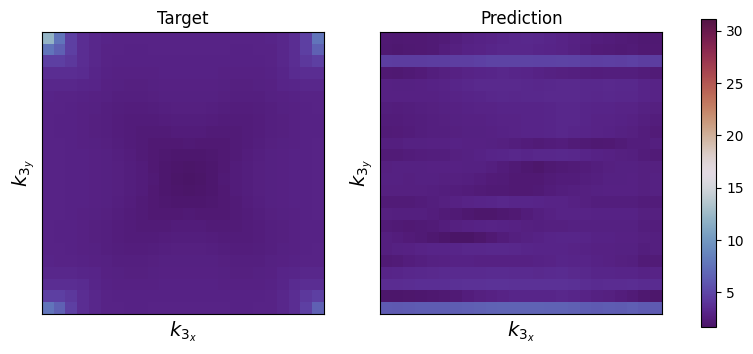

In [75]:
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file('../frgs_6d/tp0.020000_mu0.080000.h5')
i = 12
vertvis.plot_comparison_24x6(vertex6, pred6, k=3, kix=i, kiy=i, kjx=i, kjy=i, figsize=(10,4))
rmse(vertex6, pred6)

2.1074274429563435

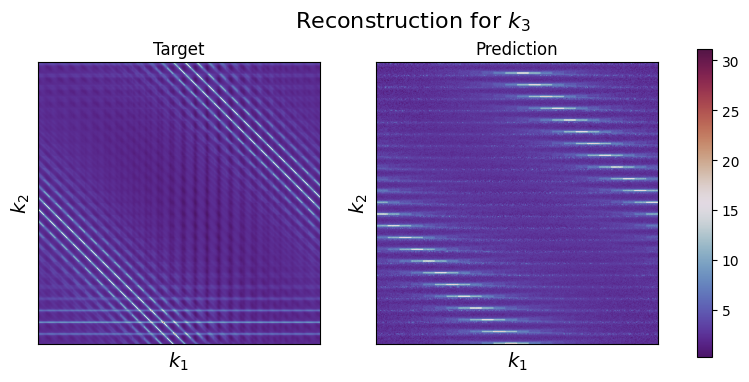

In [76]:
vertex3 = AutoEncoderVertexDataset.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
vertvis.plot_comparison(vertex3, reconstr6, 255, axis=3, figsize=(10,4))
rmse(vertex3, reconstr6)

In [55]:
i = 12
pred_slice = trainer6.predict_slice('../frgs_6d/tp0.020000_mu0.080000.h5', kix=i, kiy=i, kjx=i, kjy=i)
pred_slice.shape

100%|██████████| 24/24 [00:00<00:00, 2666.72it/s]


(24, 24)

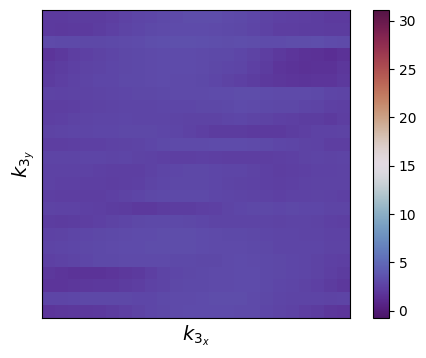

In [71]:
fig, ax, max_value = vertvis._init_plot(pred_slice, k_axis=3, figsize=(6,4))
img = vertvis._plot(pred_slice, ax, max_value, '$k_{3_x}$', '$k_{3_y}$', None, vertex6.min(), vertex6.max())
fig.colorbar(img, ax=ax)

In [16]:
reconstr3 = trainer3.predict('../frgs/tp0.010000_mu0.040000.h5', save_path='save_AUTO_ENCODER_VERTEX_BS20_2024-12-06')
reconstr3.shape

 >>> Load checkpoint from 'c:/OneDrive - TU Wien/Studium/Master_5. Semester/Masters thesis/code/LuttingerWard_from_ML/saves/vertex_v2/save_AUTO_ENCODER_VERTEX_V2_BS20_2024-12-06\version_0\checkpoints\epoch=99-step=24000.ckpt'


100%|██████████| 331776/331776 [10:15<00:00, 539.08it/s]


(576, 576, 576)

In [ ]:
ls3 = trainer3.predict('../frgs/tp0.020000_mu0.080000.h5', save_path='save_AUTO_ENCODER_VERTEX_BS20_2024-12-06', 
                     encode_only=True)
ls3.shape

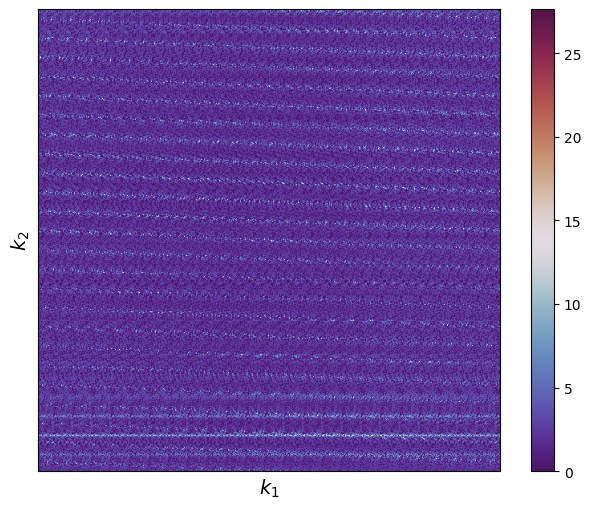

In [13]:
vertex3 = AutoEncoderVertexDataset.load_from_file('../frgs/tp0.020000_mu0.080000.h5')
vertvis.plot_comparison(vertex3, reconstr3, 255, axis=3, figsize=(10,4))

## Evaluate

In [56]:
import numpy as np


In [84]:
# vertex reconstruction error
def reconstr_err(target: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(pred - vertex) / np.linalg.norm(target)

recerr = reconstr_err(vertex, pred)
recerr

0.06782501212528207

In [ ]:
# eigenvalue reconstruction errors


eigenvalues, eigenvectors = np.linalg.eig(pred[:,:,0])
len(eigenvalues)

In [93]:
et, _ = np.linalg.eig(vertex[:,:,0])
ep, _ = np.linalg.eig(pred[:,:,0])
sorted(abs(et) - abs(ep))

[-16.603054854308738,
 -8.73705845531866,
 -6.047905939013205,
 -5.096497126487918,
 -4.0603994020076755,
 -3.437334866358647,
 -3.4278187822464403,
 -3.396372196458799,
 -3.3677542824526583,
 -2.8505365006967516,
 -2.823668178241393,
 -2.8217525135441406,
 -2.6220673415432216,
 -2.4426288425095706,
 -2.3578484465369183,
 -2.3027480266967224,
 -2.2220143601956255,
 -2.200687548866185,
 -2.1428611410338156,
 -2.1214966658602097,
 -2.0693617041357992,
 -2.023019165582013,
 -1.9820313497249349,
 -1.9265533934335526,
 -1.7446407141738831,
 -1.6362894411267455,
 -1.5986066074324925,
 -1.5238116025273243,
 -1.4974563263754108,
 -1.451441388232099,
 -1.4483221780295676,
 -1.392246150392741,
 -1.3918965853533534,
 -1.3913931561715165,
 -1.3838159191858055,
 -1.3612311033962579,
 -1.3535136655474256,
 -1.3535136655474256,
 -1.34155205642592,
 -1.3310056687461826,
 -1.3182741598726508,
 -1.3171121870598337,
 -1.304480888013221,
 -1.2270809972396535,
 -1.219796161835884,
 -1.1941885105421308,
 -1

In [ ]:
# -> different for different sections
v1, _ = np.linalg.eig(pred[:,:,2])
v2, _ = np.linalg.eig(pred[:,:,167])
sorted(abs(v1) - abs(v2))

[-5.159774691615382,
 -5.159774691615382,
 -2.670358603649456,
 -2.6452022895458676,
 -2.5365652374371646,
 -2.5365652374371646,
 -2.1973631753281104,
 -1.7622380593573803,
 -1.7145238676950103,
 -1.7145238676950103,
 -1.311740927100895,
 -1.311740927100895,
 -1.2613336869798286,
 -1.2431897554938165,
 -1.2431897554938165,
 -1.2282179235558845,
 -1.224065307041875,
 -1.1832460134965346,
 -1.1832460134965346,
 -1.1791063429646211,
 -1.1791063429646211,
 -1.1762217297304596,
 -1.1762217297304596,
 -1.1660999242415686,
 -1.1200112784989842,
 -1.06492727661748,
 -1.0227705531644466,
 -0.9889097686528343,
 -0.9781178504381902,
 -0.8937074027219114,
 -0.8710658920033509,
 -0.8172803314982096,
 -0.723009973726648,
 -0.6963801310527509,
 -0.6883332648033775,
 -0.6883332648033775,
 -0.6579163662863117,
 -0.5928350208042978,
 -0.5738081907704013,
 -0.5738081907704013,
 -0.5694149003925997,
 -0.5128420527715569,
 -0.49820122265309585,
 -0.48083723367562836,
 -0.4739914493171584,
 -0.4667365511272

In [73]:
# RMSE
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

rmse_ = rmse(vertex, pred)
rmse_

0.2557820921515644

In [71]:
# relative errors
def rel_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.average(np.divide(np.abs(target - pred), np.abs(target)))

relerr = rel_error(vertex, pred)
relerr

0.045636286180477006

In [ ]:
# dimension compression rate
import math
from src.trainer import BaseTrainer

def compression_rate(trainer: BaseTrainer) -> float:
    in_dim = trainer.get_input_size()
    if not isinstance(in_dim, int):
        hidden = [math.prod(d) for d in trainer.config.hidden_dims]
        return min(hidden) / math.prod(in_dim)
    else:
        return min(trainer.config.hidden_dims) / in_dim

compr = compression_rate(trainer)
compr

0.07407407407407407